In [37]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as tt
import random
import os
import sys
import matplotlib.pyplot as plt
from dataloader import *
sys.path.append('../')
import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [38]:
# car following models for cars or for trucks/busses? 
V_TYPE = "CARS" # CARS or TRUCKS
ENABLE_EXTRA_LOGGING = True

In [39]:
def Bayesian_IDM_pool(vt, s, dv, label_v):
    print("training size:", label_v.shape[0])
    dt = (1 / 30) * FREQ

    model = pm.Model()

    D = 5
    
    with model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * dt
            
            
        if V_TYPE == "CARS":
            mu_prior = pm.floatX(np.array([0, 0, 0, 0, 0]))
        else:
            mu_prior = np.log(np.array([0.0001, 0.1, 1.0, 0.001, 0.0001]))
            
        parameters_normalized = pm.MvNormal('mu_normalized', mu_prior, chol=np.eye(D))
        
        log_parameters = pm.Deterministic('log_mu', parameters_normalized*np.array([.3, 1., 1., .01, .5])
                                      +np.array([2., 0.69, 0.47, -.3, .51]))
       
        parameters = pm.Deterministic('mu', tt.exp(log_parameters))
        
        DELTA = 4
        
        log_s_v = pm.Uniform('log_s_v', lower=-3.0, upper=-1.0)
        s_v = pm.Deterministic('s_v', tt.exp(log_s_v))
        
        v_obs = pm.Normal('obs', mu=IDM_v(parameters[0], parameters[1], parameters[2], parameters[3],
                                         parameters[4], DELTA, s, vt, dv), sigma=s_v, observed=label_v)
        
        tr = pm.sample(1000, tune=1000, random_seed=16, init='jitter+adapt_diag_grad', chains=2,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)
    return tr, model

In [40]:
data = pd.DataFrame()
for file in os.listdir('Alafaya'):
    if file.endswith('.csv'):
        data = data.append(pd.read_csv('Alafaya/University@Alafaya-01.csv'))
data = data.reset_index()
data = data[data['frameNum'].apply(lambda x: x % FREQ == 0)]

useful_data, v_ids = extract_info(data, V_TYPE)
print(f"Received data count: {len(useful_data)}")

Cars: 2656 Trucks: 309
Data count: 309
Received data count: 309


In [41]:
import pandas as pd

new_data = []

speed_r = 0
count_r = 0

for index, group in useful_data.groupby(['carId']):
    group = group.sort_values(by=['frameNum'])
    # speed of the ego-vehicle in the next time step
    group['next_speed'] = group['speed'].shift(-1)
    group['speed_dif'] = group['next_speed'] - group['speed']
    group.drop_duplicates(subset=['frameNum'])
    # when the vehicles are stopped, the model can probably get confused on what is the right behavior
    # Also, IDM is not designed for arterial driving but rather highway driving
    group = group[(group.speed > 0.5)]
    group = group[(group.next_speed > 0.5)]
    # within a time step (1 second by default), there can't be an accelatation/decelerate more than 5 m/s^(-2)
    group = group[(abs(group.speed_dif) < 5)]
    new_data.append(group)
    
new_data = pd.concat(new_data)
# the following row dropping is weired and not sure why it keep giving non-existing rows otherwise
new_data = new_data[new_data.index < 414976] # drop all rows beyond what we have in the dataset
# drop rows if there are any rows having NaNs for required features
new_data.dropna(inplace=True, subset=["speed", "next_speed", "headway", "relative_speed"])

#new_data = new_data.iloc[0:30] 
print(f"\nRelevant and useful data count: {len(new_data)}")

if ENABLE_EXTRA_LOGGING:
    # write the dataset to csv file for later inspection (if needed)
    new_data.to_csv('out_final_data.csv', index=False)

speed = new_data['speed'].values
relative_speed = new_data['relative_speed'].values
headway = new_data['headway'].values 
next_speed = new_data['next_speed'].values


Relevant and useful data count: 30


In [42]:
# direct stats from the dataset
print(f"Desired speed mean and std: {new_data['speed'].mean()} - {new_data['speed'].std()}")
print(f"Headway mean and std: {new_data['headway'].mean()} - {new_data['headway'].std()}")
new_data['vel_diff'] = new_data['next_speed'] - new_data['speed']
print(f"Desired acceleration mean and std: {(new_data['vel_diff'] > 0).mean()} - {(new_data['vel_diff'] > 0).std()}")
print(f"Desired deceleration mean and std: {(new_data['vel_diff'] < 0).mean()} - {(new_data['vel_diff'] < 0).std()}")

Desired speed mean and std: 7.711582451248071 - 5.32429916013676
Headway mean and std: 15.437513226148072 - 7.215732923147046
Desired acceleration mean and std: 0.7666666666666667 - 0.4301830671520763
Desired deceleration mean and std: 0.23333333333333334 - 0.43018306715207627


array([[<AxesSubplot: title={'center': 'speed_dif'}>]], dtype=object)

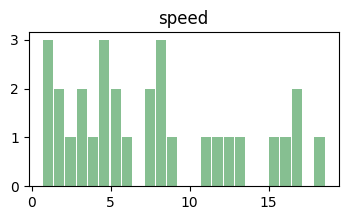

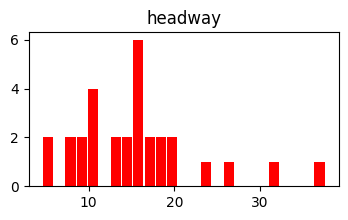

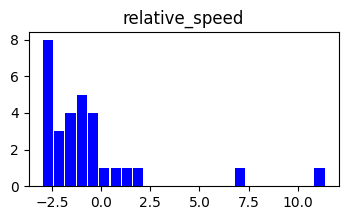

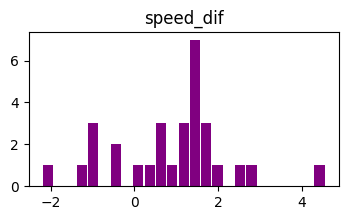

In [43]:
# some further plotting of the stats taken from the dataset 
new_data.hist(column='speed', bins=25, grid=False, figsize=(4,2), color='#86bf91', zorder=2, rwidth=0.9)
new_data.hist(column='headway', bins=25, grid=False, figsize=(4,2), color='red', zorder=2, rwidth=0.9)
new_data.hist(column='relative_speed', bins=25, grid=False, figsize=(4,2), color='blue', zorder=2, rwidth=0.9)
new_data.hist(column='speed_dif', bins=25, grid=False, figsize=(4,2), color='purple', zorder=2, rwidth=0.9)

In [44]:
tr, model = Bayesian_IDM_pool(speed, headway, relative_speed, next_speed)

training size: 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [mu_normalized, log_s_v]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


In [45]:
az.summary(tr, var_names=["mu","log_mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],17.309,0.906,15.764,19.010,0.020,0.015,2104.0,1393.0,1.0
mu[1],0.692,0.596,0.021,1.840,0.021,0.015,718.0,1098.0,1.0
mu[2],0.572,0.135,0.311,0.818,0.004,0.003,1069.0,634.0,1.0
mu[3],0.697,0.007,0.683,0.708,0.000,0.000,2372.0,1346.0,1.0
mu[4],1.241,0.134,1.009,1.496,0.003,0.002,2023.0,1352.0,1.0
log_mu[0],2.850,0.052,2.758,2.945,0.001,0.001,2104.0,1393.0,1.0
log_mu[1],-0.808,1.036,-2.601,0.950,0.039,0.028,718.0,1098.0,1.0
log_mu[2],-0.590,0.260,-1.063,-0.132,0.009,0.007,1069.0,634.0,1.0
log_mu[3],-0.362,0.010,-0.379,-0.343,0.000,0.000,2372.0,1346.0,1.0
log_mu[4],0.210,0.106,0.009,0.402,0.002,0.002,2023.0,1352.0,1.0


In [46]:
df = tr.posterior.mu.to_dataframe()
results = pd.DataFrame()
for i in range(5):
    col = df.iloc[df.index.get_level_values('mu_dim_0') == i, 0]
    results['mu_{}'.format(i)] = list(col)

In [47]:
results.mean(axis=0)

mu_0    17.309342
mu_1     0.691562
mu_2     0.571691
mu_3     0.696570
mu_4     1.240931
dtype: float64

In [48]:
final_mean_params = results.mean(axis=0)

In [49]:
results.cov()

,mu_0,mu_1,mu_2,mu_3,mu_4
mu_0,0.820044,-0.029130,0.032802,-0.000168,-0.006805
mu_1,-0.029130,0.355389,-0.041195,0.000146,-0.011104
mu_2,0.032802,-0.041195,0.018320,-0.000035,0.002536
mu_3,-0.000168,0.000146,-0.000035,0.000044,-0.000016
mu_4,-0.006805,-0.011104,0.002536,-0.000016,0.017854


In [50]:
# check the quality of learned models
rdata = pd.DataFrame()
for file in os.listdir('Alafaya'):
    if file.endswith('.csv'):
        rdata = rdata.append(pd.read_csv('Alafaya/University@Alafaya-01.csv'))
rdata = rdata.reset_index()
rdata = rdata[rdata['frameNum'].apply(lambda x: x % FREQ == 0)]

ego_velocities, ego_heads, leader_velocities, leader_tails = extract_car_info(rdata, car_ids=v_ids) 
assert len(ego_velocities) == len(leader_velocities), "Both ego-vehicle and leader velocities should be available for same number of steps"

In [51]:
# simulations 
dt = (1 / 30) * FREQ
def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * dt
            
VMAX = final_mean_params[0]
DSAFE = final_mean_params[1]
TSAFE = final_mean_params[2]
AMAX = final_mean_params[3]
AMIN = final_mean_params[4]
DELTA = 4

def simulate(ego_velocities, ego_heads, leader_velocities, leader_tails):
    v = ego_velocities[0]
    s = ego_heads[0]
    d = s
    delta_t = 1

    simulated_ego_velocities = [v]
    simulated_ego_heads = [s]
    for i in range(len(ego_velocities)-1):
        vt = v
        dv = vt - leader_velocities[i]
        s = leader_tails[i] - d
        a = max(-1*AMIN, min(AMAX, IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv)))
        u = vt
        v = max(0, min(VMAX, u + a*delta_t))
        d = min(leader_tails[i], max(d, d + v))
        simulated_ego_velocities.append(v)
        simulated_ego_heads.append(d)
    
    return simulated_ego_velocities, simulated_ego_heads


In [52]:
simulated_ego_velocities = {}
simulated_ego_heads = {}
for car in v_ids:
    s_e_v, s_e_h = simulate(ego_velocities[car], ego_heads[car], leader_velocities[car], leader_tails[car])
    simulated_ego_velocities[car] = s_e_v
    simulated_ego_heads[car] = s_e_h

import statistics as st
print(st.mean(simulated_ego_velocities)/len(simulated_ego_velocities))

57.193359375


In [53]:
v_error = 0 
l_error = 0

for car in v_ids:
    for i in range(len(simulated_ego_velocities[car])):
        v_error += ((simulated_ego_velocities[car][i] - ego_velocities[car][i])**2)**0.5
        l_error += ((simulated_ego_heads[car][i] - ego_heads[car][i])**2)**0.5

In [54]:
print(f"Predicted desired velocity: {final_mean_params[0]}")
print(f"Predicted minimum spacing: {final_mean_params[1]}")
print(f"Predicted desired time headway: {final_mean_params[2]}")
print(f"Predicted acceleration: {final_mean_params[3]}")
print(f"Predicted deceleration: {final_mean_params[4]}")
print("")

print(f"Per vehicle velocity RMSE: {v_error/len(v_ids)}")
print(f"Per vehicle location RMSE: {l_error/len(v_ids)}")

# direct stats from the dataset
print(f"Desired speed mean and std: {new_data['speed'].mean()} - {new_data['speed'].std()}")
print(f"Headway mean and std: {new_data['headway'].mean()} - {new_data['headway'].std()}")
new_data['vel_diff'] = new_data['next_speed'] - new_data['speed']
print(f"Desired acceleration mean and std: {(new_data['vel_diff'] > 0).mean()} - {(new_data['vel_diff'] > 0).std()}")
print(f"Desired deceleration mean and std: {(new_data['vel_diff'] < 0).mean()} - {(new_data['vel_diff'] < 0).std()}")

Predicted desired velocity: 17.309341928624264
Predicted minimum spacing: 0.6915621614768203
Predicted desired time headway: 0.5716913708148281
Predicted acceleration: 0.6965701267871068
Predicted deceleration: 1.2409305254117207

Per vehicle velocity RMSE: 34.046108207651535
Per vehicle location RMSE: 310.30877105082266
Desired speed mean and std: 7.711582451248071 - 5.32429916013676
Headway mean and std: 15.437513226148072 - 7.215732923147046
Desired acceleration mean and std: 0.7666666666666667 - 0.4301830671520763
Desired deceleration mean and std: 0.23333333333333334 - 0.43018306715207627


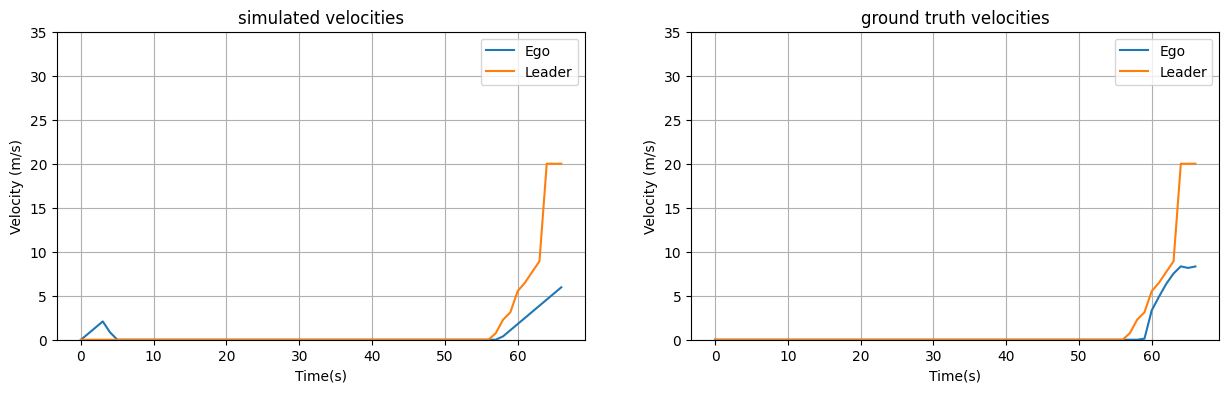

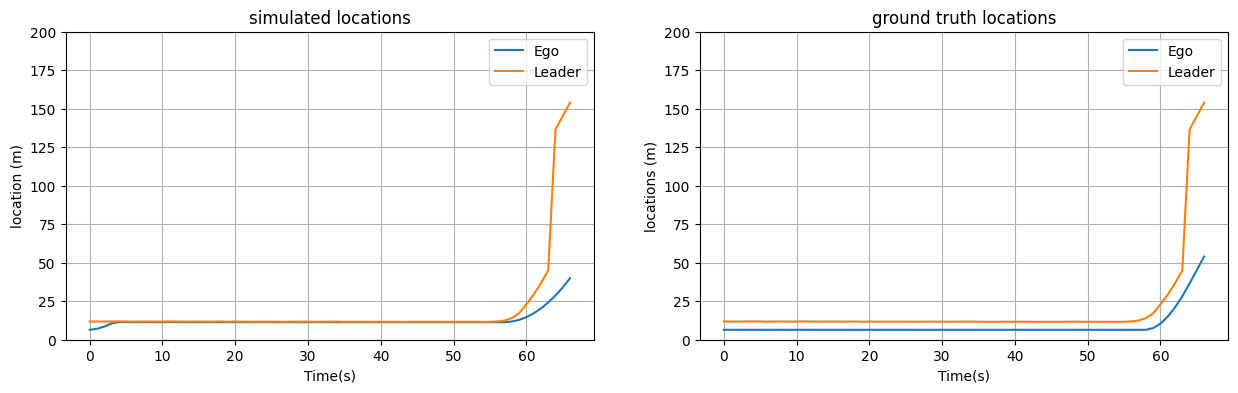

In [55]:
car_to_plot = 0

x = np.arange(len(simulated_ego_heads[v_ids[car_to_plot]]))

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(15)


axs[0].plot(x, simulated_ego_velocities[v_ids[car_to_plot]])
axs[0].plot(x, leader_velocities[v_ids[car_to_plot]])
axs[1].plot(x, ego_velocities[v_ids[car_to_plot]])
axs[1].plot(x, leader_velocities[v_ids[car_to_plot]])

axs[0].set_title('simulated velocities')
axs[1].set_title('ground truth velocities')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Velocity (m/s)')
axs[1].set_xlabel('Time(s)')
axs[1].set_ylabel('Velocity (m/s)')
axs[0].legend(['Ego', 'Leader'])
axs[1].legend(['Ego', 'Leader'])
axs[0].set_ylim(0,35)
axs[1].set_ylim(0,35)
axs[0].grid()
axs[1].grid()
plt.show()

fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(15)

axs[0].plot(x, simulated_ego_heads[v_ids[car_to_plot]])
axs[0].plot(x, leader_tails[v_ids[car_to_plot]])
axs[1].plot(x, ego_heads[v_ids[car_to_plot]])
axs[1].plot(x, leader_tails[v_ids[car_to_plot]])

axs[0].set_title('simulated locations')
axs[1].set_title('ground truth locations')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('location (m)')
axs[1].set_xlabel('Time(s)')
axs[1].set_ylabel('locations (m)')
axs[0].legend(['Ego', 'Leader'])
axs[1].legend(['Ego', 'Leader'])
axs[0].set_ylim(0,200)
axs[1].set_ylim(0,200)
axs[0].grid()
axs[1].grid()
plt.show()


In [56]:
df = tr.posterior.mu.to_dataframe()
results = pd.DataFrame()
for i in range(5):
    col = df.iloc[df.index.get_level_values('mu_dim_0') == i, 0]
    results['mu_{}'.format(i)] = list(col)
results.to_csv(f'idm_{V_TYPE.lower()}.csv', index=False)